In [10]:
#!pip install ucimlrepo shap matplotlib seaborn xgboost
# https://archive.ics.uci.edu/dataset/109/wine

In [ ]:
# credit : Dr. Maryam Miradi - https://www.youtube.com/watch?v=PI4qIe3iBrw&t=350s

In [26]:
# GENERAL
import warnings

# DATA
from ucimlrepo import fetch_ucirepo

# DATA Processing
import pandas as pd
import numpy as np

# Visualisation
import matplotlib.pyplot as plt
import seaborn as sns

# Scikitlearn
from sklearn.exceptions import ConvergenceWarning
from sklearn.model_selection import cross_val_score, KFold, train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import make_scorer, mean_squared_error, r2_score, mean_absolute_error
from sklearn.pipeline import Pipeline
from sklearn.datasets import make_regression
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer


## 1. Linear Models
from sklearn.linear_model import (
    LinearRegression, Ridge, Lasso, ElasticNet, Lars, LassoLars,
    OrthogonalMatchingPursuit, BayesianRidge, ARDRegression, SGDRegressor,
    PassiveAggressiveRegressor, HuberRegressor, QuantileRegressor
)

## 2. SVM Models
from sklearn.svm import SVR, NuSVR, LinearSVR

## 3. Nearest Neighbors
from sklearn.neighbors import KNeighborsRegressor, RadiusNeighborsRegressor

## 4. Tree Based Models
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, GradientBoostingRegressor, AdaBoostRegressor, BaggingRegressor, VotingRegressor, StackingRegressor

# XGBoost
from xgboost import XGBRegressor, plot_importance

## 5. Gaussian Process
from sklearn.gaussian_process import GaussianProcessRegressor

## 6. Discrimant Analysis
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis

## 7. NN
from sklearn.neural_network import MLPRegressor

## 8. Naive Bayes
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB, ComplementNB, CategoricalNB



# SHAP
import shap


In [27]:
def load_data_from_uci(id_code):

  # fetch dataset
  uci_data = fetch_ucirepo(id=id_code)

  # data (as pandas dataframes)
  input_features = uci_data.data.features
  target_feature = uci_data.data.targets
  metadata = uci_data.data.metadata
  variables_info = uci_data.data.variables

  return input_features, target_feature, metadata, variables_info

In [28]:
input_features, target_feature, metadata, variables_info =  load_data_from_uci(id_code = 109)

In [29]:
input_features.head(10)

,Alcohol,Malicacid,Ash,Alcalinity_of_ash,Magnesium,Total_phenols,Flavanoids,Nonflavanoid_phenols,Proanthocyanins,Color_intensity,Hue,0D280_0D315_of_diluted_wines,Proline
0,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735
5,14.20,1.76,2.45,15.2,112,3.27,3.39,0.34,1.97,6.75,1.05,2.85,1450
6,14.39,1.87,2.45,14.6,96,2.50,2.52,0.30,1.98,5.25,1.02,3.58,1290
7,14.06,2.15,2.61,17.6,121,2.60,2.51,0.31,1.25,5.05,1.06,3.58,1295
8,14.83,1.64,2.17,14.0,97,2.80,2.98,0.29,1.98,5.20,1.08,2.85,1045
9,13.86,1.35,2.27,16.0,98,2.98,3.15,0.22,1.85,7.22,1.01,3.55,1045


In [30]:
input_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 178 entries, 0 to 177
Data columns (total 13 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Alcohol                       178 non-null    float64
 1   Malicacid                     178 non-null    float64
 2   Ash                           178 non-null    float64
 3   Alcalinity_of_ash             178 non-null    float64
 4   Magnesium                     178 non-null    int64  
 5   Total_phenols                 178 non-null    float64
 6   Flavanoids                    178 non-null    float64
 7   Nonflavanoid_phenols          178 non-null    float64
 8   Proanthocyanins               178 non-null    float64
 9   Color_intensity               178 non-null    float64
 10  Hue                           178 non-null    float64
 11  0D280_0D315_of_diluted_wines  178 non-null    float64
 12  Proline                       178 non-null    int64  
dtypes: fl

In [31]:
target_feature.head()

,class
0,1
1,1
2,1
3,1
4,1


In [32]:
input_features.describe().T

,count,mean,std,min,25%,50%,75%,max
Alcohol,178.0,13.000618,0.811827,11.03,12.3625,13.050,13.6775,14.83
Malicacid,178.0,2.336348,1.117146,0.74,1.6025,1.865,3.0825,5.80
Ash,178.0,2.366517,0.274344,1.36,2.2100,2.360,2.5575,3.23
Alcalinity_of_ash,178.0,19.494944,3.339564,10.60,17.2000,19.500,21.5000,30.00
Magnesium,178.0,99.741573,14.282484,70.00,88.0000,98.000,107.0000,162.00
Total_phenols,178.0,2.295112,0.625851,0.98,1.7425,2.355,2.8000,3.88
Flavanoids,178.0,2.029270,0.998859,0.34,1.2050,2.135,2.8750,5.08
Nonflavanoid_phenols,178.0,0.361854,0.124453,0.13,0.2700,0.340,0.4375,0.66
Proanthocyanins,178.0,1.590899,0.572359,0.41,1.2500,1.555,1.9500,3.58
Color_intensity,178.0,5.058090,2.318286,1.28,3.2200,4.690,6.2000,13.00


In [33]:
input_features.isna().sum()

Alcohol                         0
Malicacid                       0
Ash                             0
Alcalinity_of_ash               0
Magnesium                       0
Total_phenols                   0
Flavanoids                      0
Nonflavanoid_phenols            0
Proanthocyanins                 0
Color_intensity                 0
Hue                             0
0D280_0D315_of_diluted_wines    0
Proline                         0
dtype: int64

In [34]:
column_mapping = {
    'X1': 'Alcohol',
    'X2': 'Malicacid',
    'X3': 'Ash',
    'X4': 'Alcalinity_of_ash',
    'X5': 'Magnesium',
    'X6': 'Total_phenols',
    'X7': 'Flavanoids',
    'X8': 'Nonflavanoid_phenols',
    'X9': 'Proanthocyanins',
    'X10': 'Color_intensity',
    'X11': 'Hue',
    'X12':'0D280_0D315_of_diluted_wines',
    'X13':'Proline'

}

input_features.rename(columns=column_mapping, inplace=True)

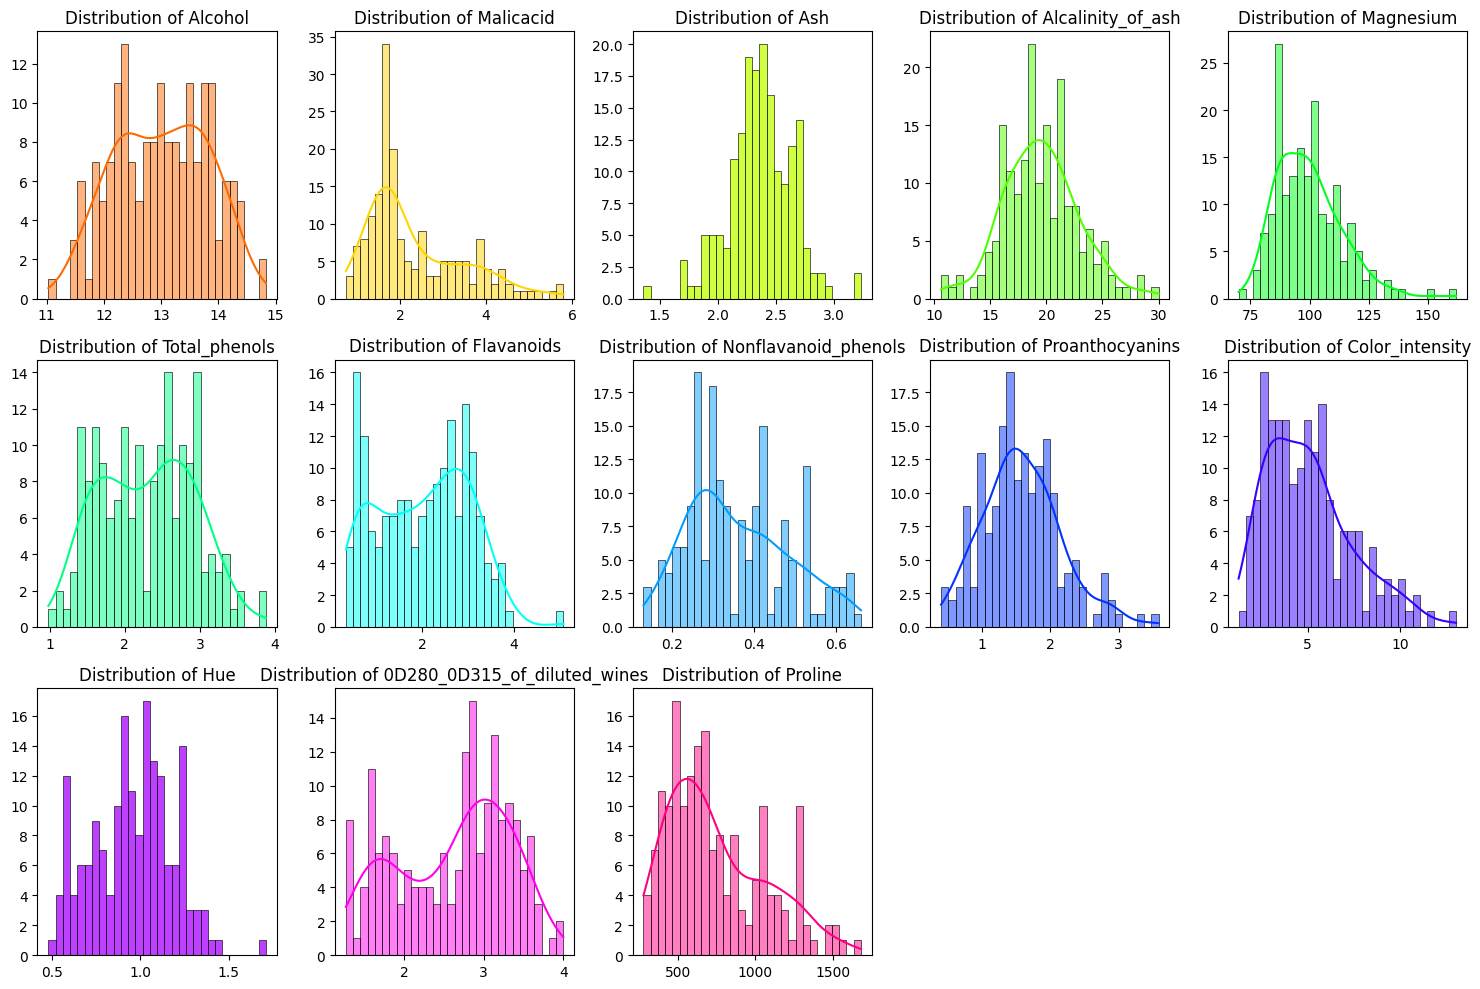

In [35]:
# Plot distribution of all input features
input_features_names = input_features.columns

plt.figure(figsize=(15, 10))
colors = sns.color_palette("hsv", len(input_features_names))

for i, (feature, color) in enumerate(zip(input_features_names, colors), 1):
    plt.subplot(3, 5, i)
    if feature in ['Ash', 'Hue']:
        sns.histplot(input_features[feature], kde=False, color=color, bins=30)
    else:
        sns.histplot(input_features[feature], kde=True, color=color, bins=30)
    plt.title(f'Distribution of {feature}')
    plt.xlabel('')
    plt.ylabel('')

plt.tight_layout()
plt.show()

In [36]:
# Define models
regression_models = {
    'Linear Regression': LinearRegression(),
    'Ridge': Ridge(),
    'Lasso': Lasso(),
    'ElasticNet': ElasticNet(),
    'LARS': Lars(),
    'LassoLARS': LassoLars(),
    'OMP': OrthogonalMatchingPursuit(),
    'BayesianRidge': BayesianRidge(),
    'ARD': ARDRegression(),
    'SGD': SGDRegressor(max_iter=1000, tol=1e-3),
    'PassiveAggressive': PassiveAggressiveRegressor(max_iter=1000, tol=1e-3),
    'Huber': HuberRegressor(),
    'Quantile': QuantileRegressor(solver='highs')
}

In [37]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

Mean Squared Error: 0.2017590307608254
R^2 Score: 0.6241637957918111


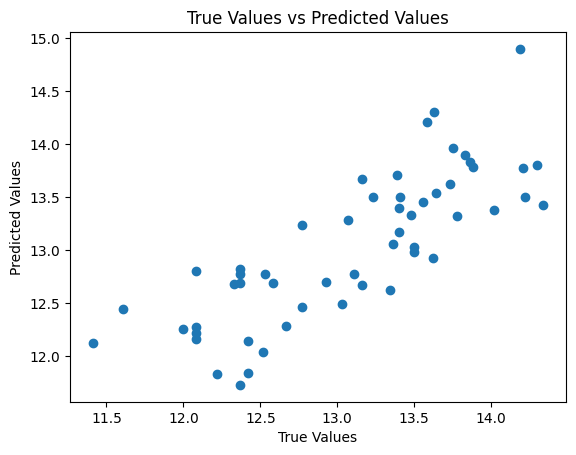

In [40]:
df = pd.DataFrame(input_features)

# Drop rows with missing values
df = df.dropna()

# Define features (X) and target variable (y)
X = df.drop(columns=['Alcohol'])
y = df['Alcohol']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Initialize and train the linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error:", mse)
print("R^2 Score:", r2)

# Plotting True Values vs. Predicted Values
plt.scatter(y_test, y_pred)
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('True Values vs Predicted Values')
plt.show()